# Predicting house price using regression techniques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew, probplot


from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#reading all the files as dataframes
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

In [3]:
print("shape of train: ", train.shape)
print("shape of test: ",test.shape)
print("shape of submission: ",sub.shape)

shape of train:  (1460, 81)
shape of test:  (1459, 80)
shape of submission:  (1459, 2)


In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#Check and drop Id column in train and test
if(train['Id'].nunique() == len(train) and test['Id'].nunique() == len(test)):
    train_id, test_id = train['Id'], test['Id']
    train.drop('Id', axis = 1, inplace = True)
    test.drop('Id', axis = 1, inplace = True)

## EDA

#### Let's get the dependent variable and its descriptive statistics

In [7]:
for c in train.columns:
    if c not in test.columns:
        print("The dependent variable is %s " %c)

train[c].describe()

The dependent variable is SalePrice 


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

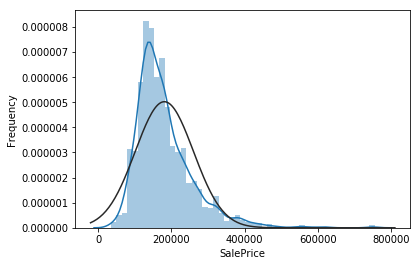

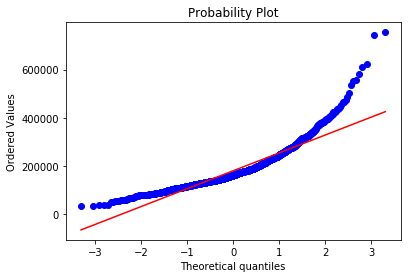

In [8]:
#Check to see if the target variable follows a normal distribution
sns.distplot(train['SalePrice'], fit = norm)
plt.ylabel('Frequency')
plt.show()

probplot(train['SalePrice'], plot=plt)
plt.show()

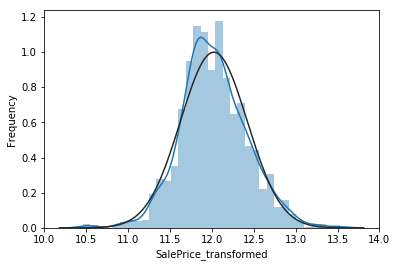

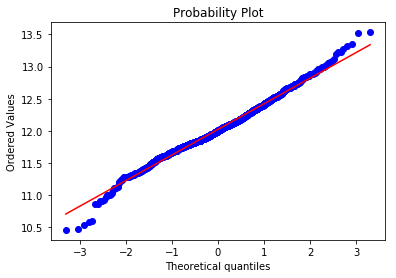

In [9]:
# Log transforming target column to resemble a normal distribution 
train["SalePrice_transformed"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice_transformed'], fit = norm)
plt.ylabel('Frequency')
plt.show()

probplot(train['SalePrice_transformed'], plot=plt)
plt.show()

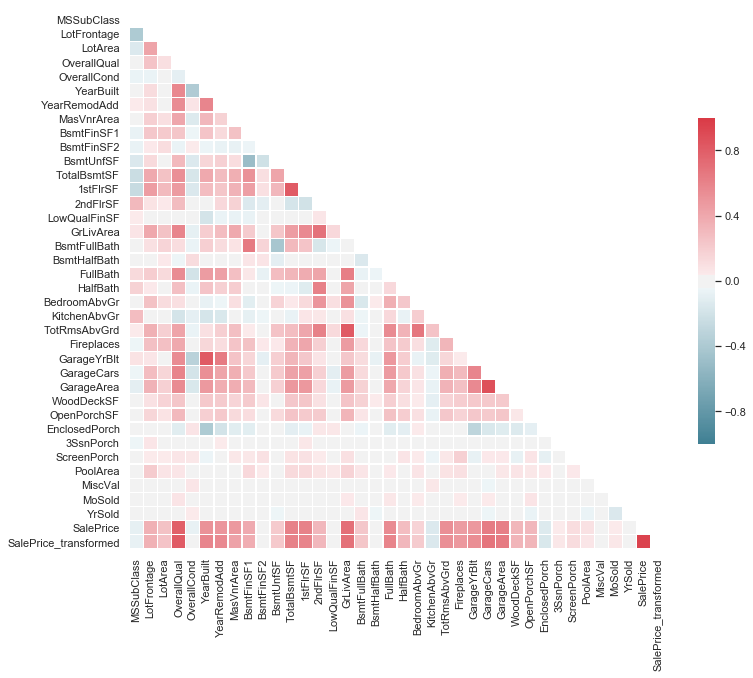

In [10]:
#Correlation among values
#Finding correlation
sns.set(style="white")
train_corr = train.corr()

mask = np.zeros_like(train_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (12,12))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(train_corr, mask=mask, cmap=cmap, vmax=1, vmin = -1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

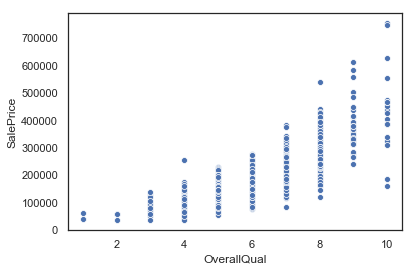

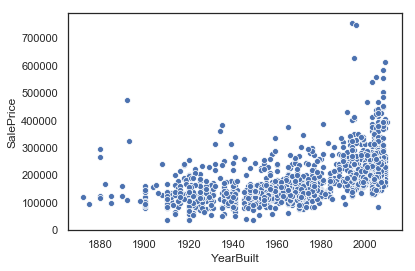

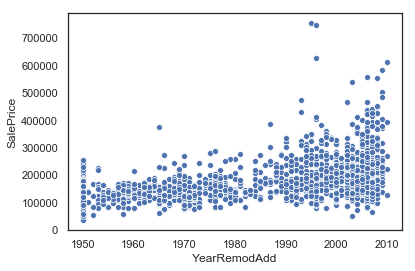

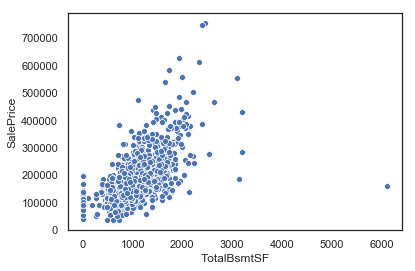

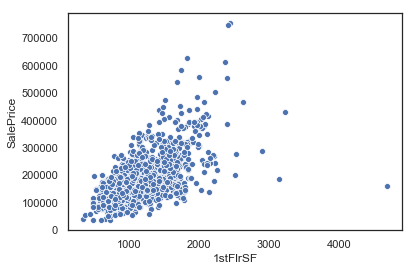

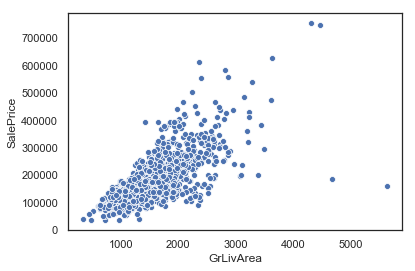

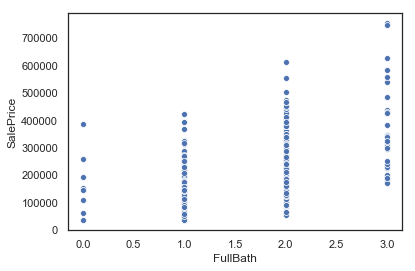

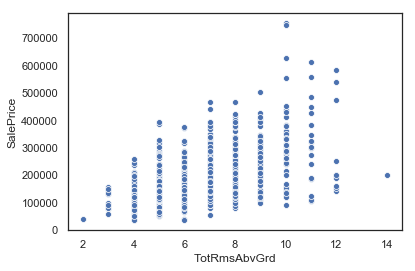

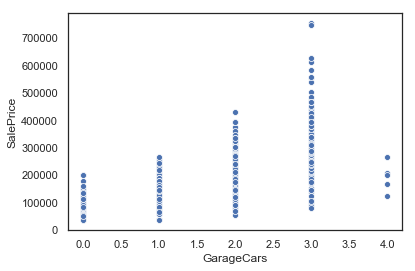

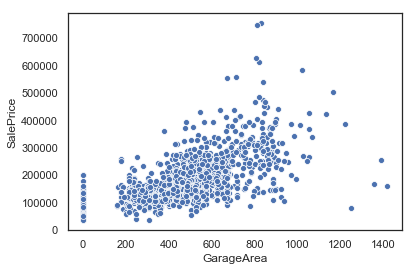

In [11]:
for i in range(train.shape[1]):
    if(train.iloc[:,i].dtype == 'int64' or train.iloc[:,i].dtype == 'float64'):
        if(abs(train['SalePrice'].corr(train.iloc[:,i])) >= 0.5 and\
           abs(train['SalePrice'].corr(train.iloc[:,i])) <= 0.9):
                ax = sns.scatterplot(train.iloc[:,i], train['SalePrice'])
                plt.show()

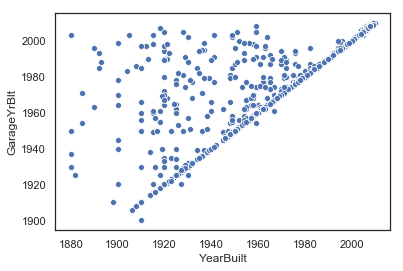

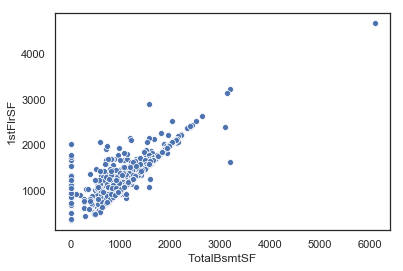

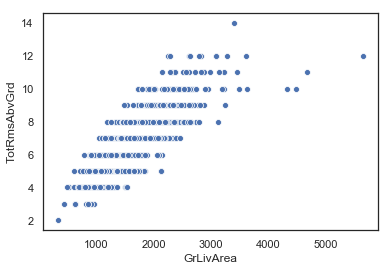

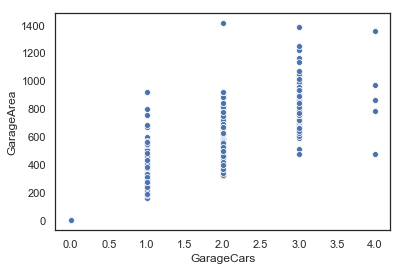

In [12]:
#Other values that have a high positive correlation are
for i in range(0,len(train_corr)-2):
    for j in range(i+1, len(train_corr)-2):
        if(abs(train_corr.iloc[i,j]) > 0.7):
            ax = sns.scatterplot(train.loc[:, (train_corr.iloc[:,i].name)], \
                                 train.loc[:, (train_corr.iloc[:,j].name)])
            plt.show()

Histogram of SalePrice:


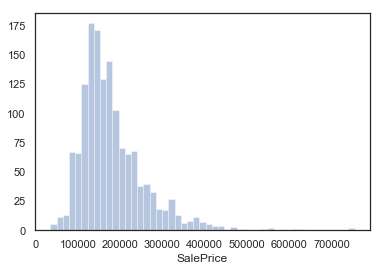

Histogram of LotArea:


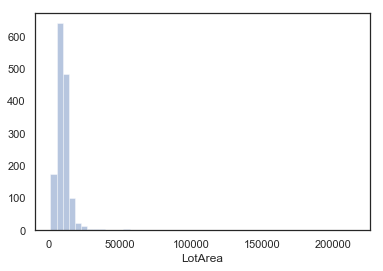

Histogram of YearBuilt:


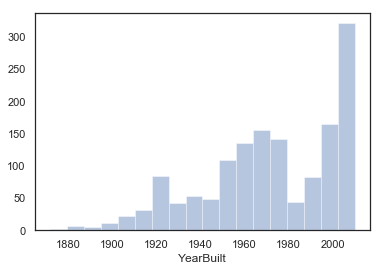

Histogram of YearRemodAdd:


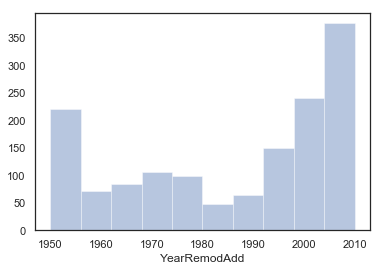

Histogram of GrLivArea:


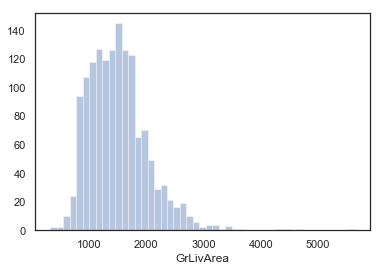

Histogram of TotRmsAbvGrd:


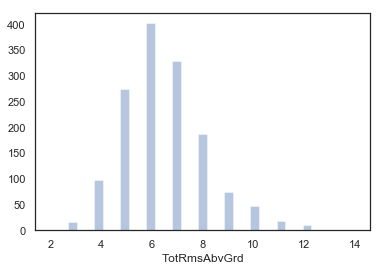

Histogram of MoSold:


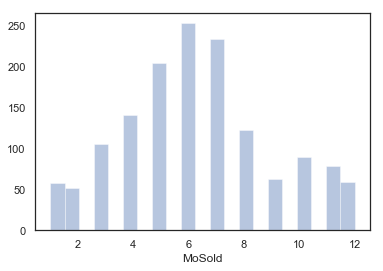

In [13]:
#Histogram plots
hist_columns = ['SalePrice','LotArea', 'YearBuilt','YearRemodAdd','GrLivArea',\
       'TotRmsAbvGrd', 'MoSold']
for col in hist_columns:
    print("Histogram of "+str(train[col].name)+":")
    sns.distplot(train[col], kde = False)
    plt.show()

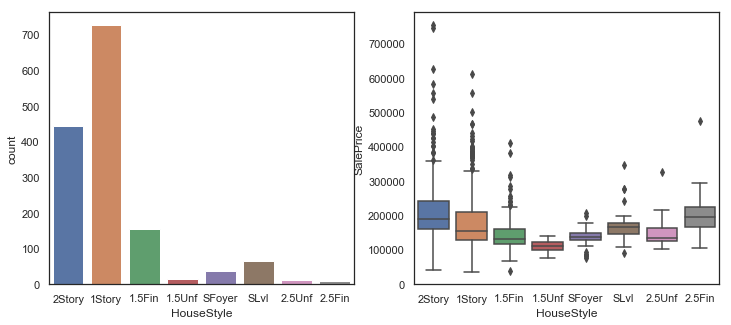

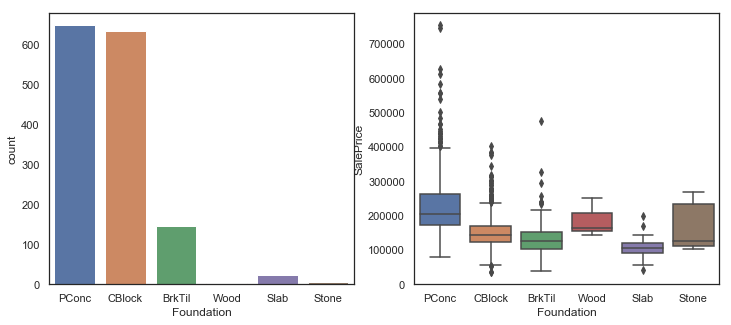

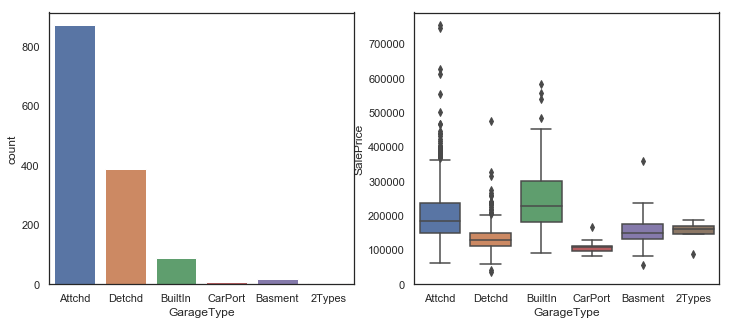

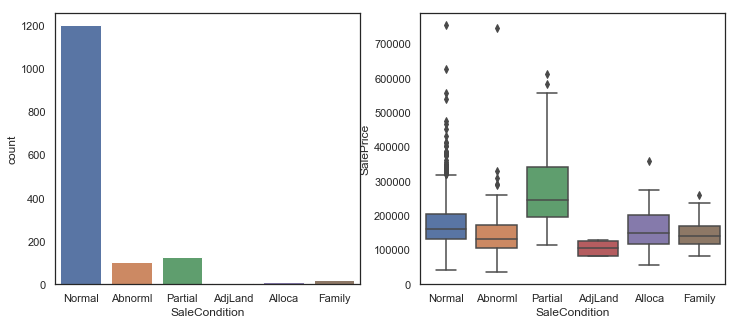

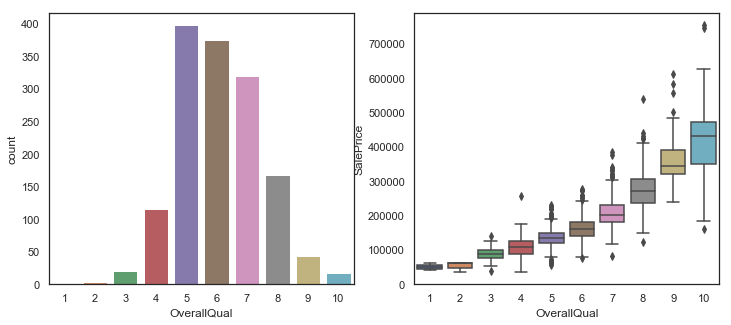

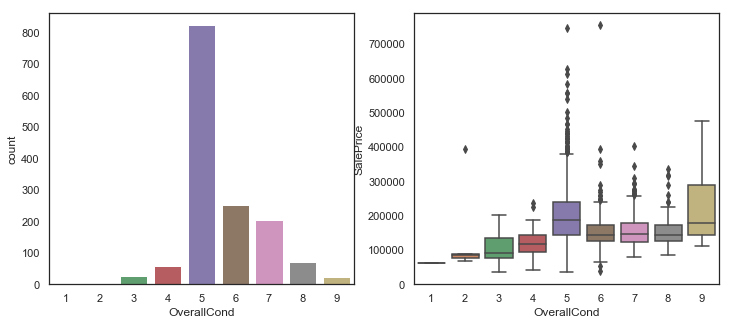

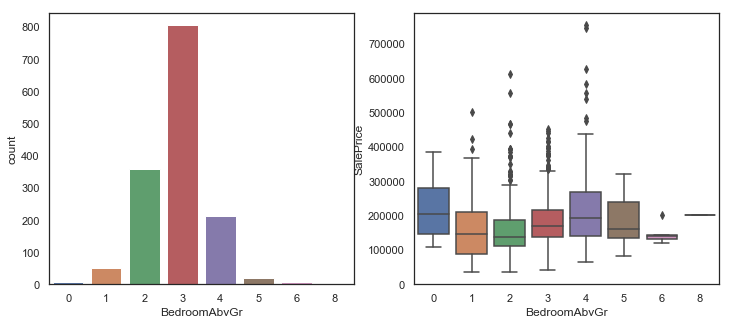

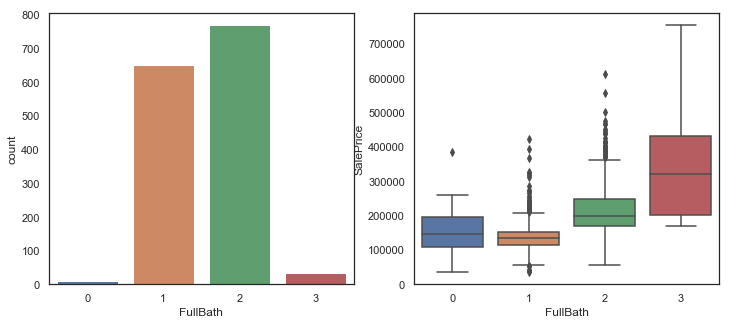

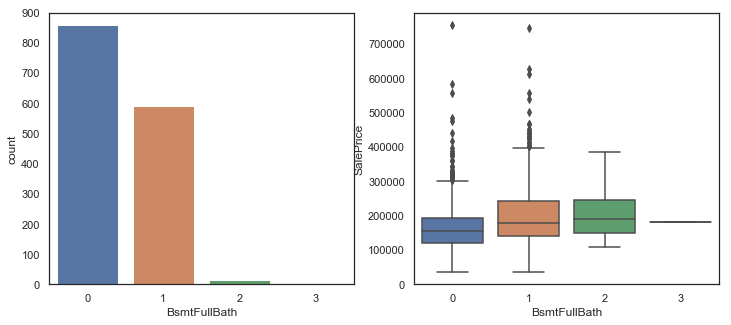

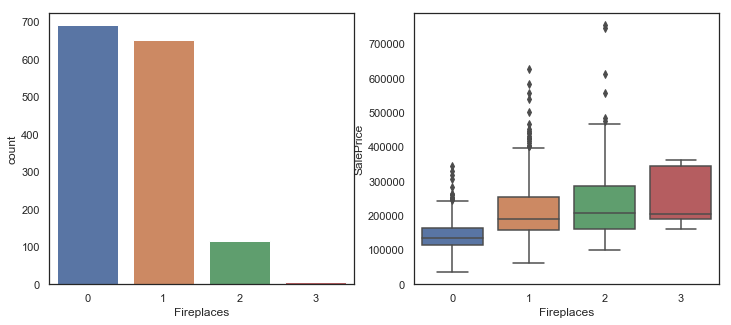

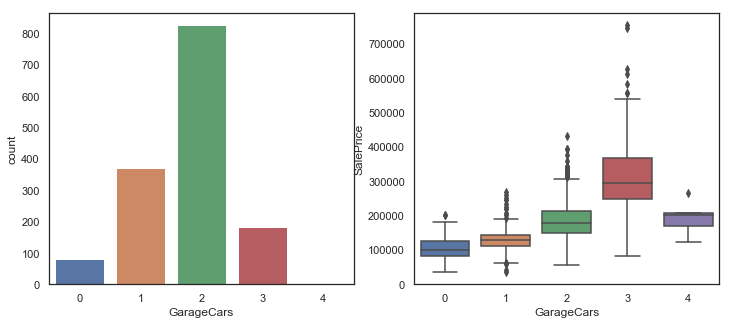

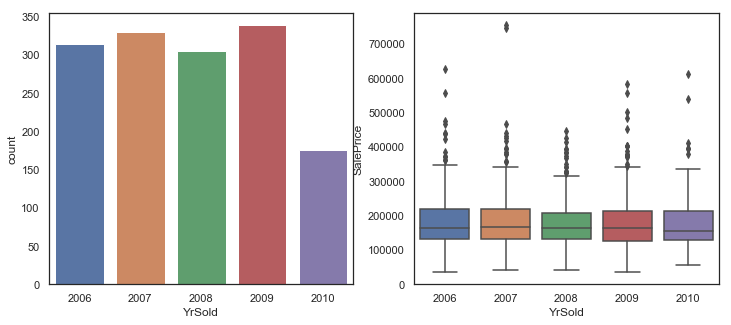

In [14]:
count_box_col = ['HouseStyle', 'Foundation','GarageType','SaleCondition',\
                     'OverallQual', 'OverallCond', 'BedroomAbvGr','FullBath',\
                     'BsmtFullBath', 'Fireplaces', 'GarageCars', 'YrSold']

for col in count_box_col:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1 = sns.countplot(train[col], ax = ax1)
    ax2 = sns.boxplot(train[col], train['SalePrice'], ax=ax2)

Boxplot and Pie chart of BsmtQual:


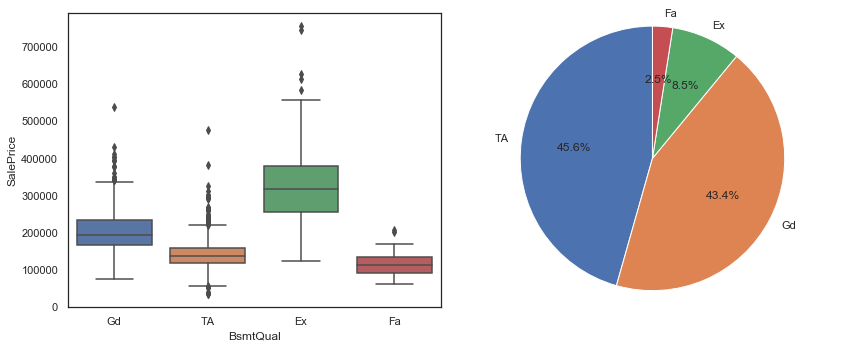

Boxplot and Pie chart of BsmtCond:


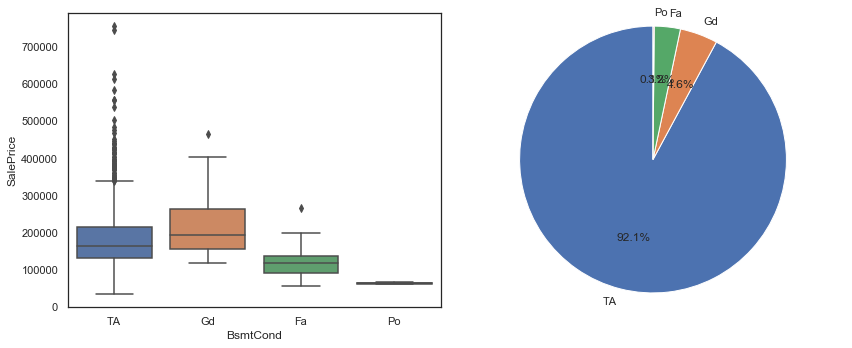

Boxplot and Pie chart of BsmtExposure:


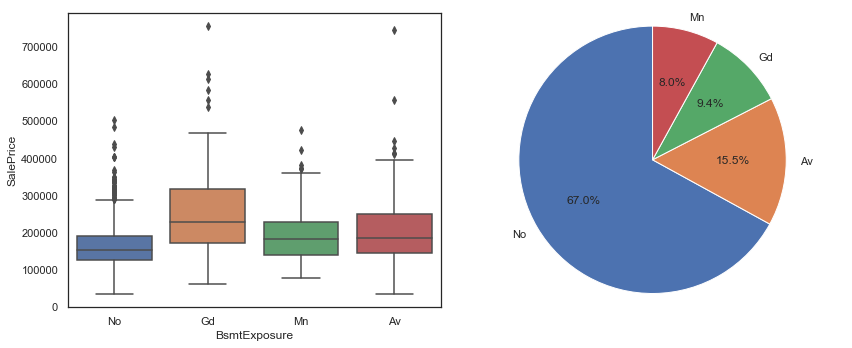

Boxplot and Pie chart of BsmtFinType1:


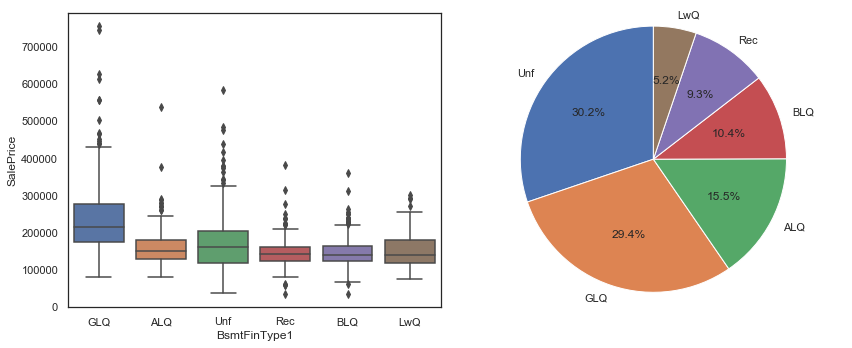

Boxplot and Pie chart of BsmtFinType2:


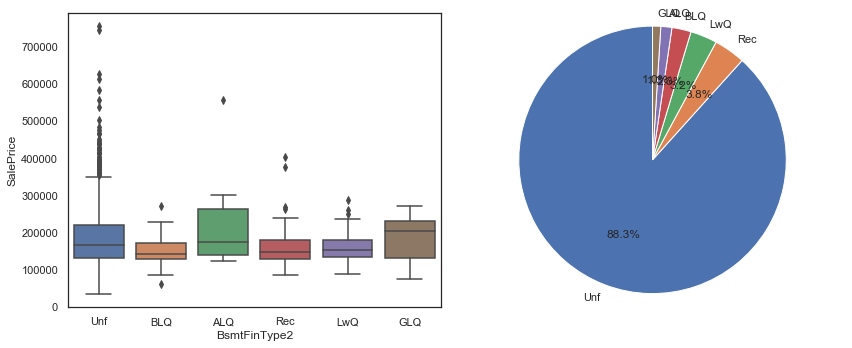

In [15]:
#Basement features
pie_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in pie_cols:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1=sns.boxplot(train[col], train['SalePrice'], ax=ax1)
    sample_df = pd.DataFrame(train[col].value_counts()).reset_index()
    sample_df.columns = [col, 'number']
    #fig, ax2 = plt.subplots(figsize=(5,5))
    print("Boxplot and Pie chart of "+col+":")
    ax2.pie(sample_df['number'], labels=sample_df[col],\
       autopct='%1.1f%%', startangle = 90)
    ax2.axis('equal')  
    plt.tight_layout()
    plt.show()

In [ ]:
for col in train.columns:
    if(train[col].dtype == 'int64'):
        if((train[col].nunique() < 12) and (train[col].nunique() > 3)):
            print(train[col].name)
            print(train[col].isnull().sum(axis=0))
            print(train[col].value_counts())

In [ ]:
#Feature Engineering

In [ ]:
#Combining train and test 
y_SalePrice = train['SalePrice']
y_train = train['SalePrice_transformed'] 
train.drop(['SalePrice', 'SalePrice_transformed'], axis = 1, inplace = True)
df = train.copy()
df = df.append(test).reset_index(drop = True)

### Handling missing values

In [ ]:
#Combining train and test 
y_SalePrice = train['SalePrice']
y_train = train['SalePrice_transformed'] 
train.drop(['SalePrice', 'SalePrice_transformed'], axis = 1, inplace = True)
df = train.copy()
df = df.append(test).reset_index(drop = True)

In [ ]:
#Get datatypes of columns
print("Datatypes of columns: ")
print(df.dtypes.value_counts())


print('\nNumber of columns with missing values is {}'.\
      format(sum(df.isnull().sum(axis=0) != 0)))

In [ ]:
plt.figure(figsize=(8,12))
missing_df = df.isnull().sum(axis=0).sort_values(ascending=False).reset_index().head(34)
missing_df.columns = ['Feature', 'Number of missing values']
ax = sns.barplot(x="Number of missing values", y="Feature", data=missing_df)

In [ ]:
#Separating train and test before imputing missing values

In [ ]:
train = df.loc[:len(train)-1,]
test = df.loc[len(train):,]

In [ ]:
for col in df.columns:
    if(df[col].isnull().sum() != 0):
        if(df[col].dtype == 'object'):
            df[col].fillna('None', inplace = True)
        else:
            df[col].fillna(df[col].mean(), inplace = True)

In [ ]:
for col in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    df[col] = df[col].astype(str)

In [ ]:
for col in df.columns:
    if(df[col].dtype != 'object'):
        if(abs(df[col].skew()) > 0.5):
            df[col] = np.log1p(df[col])

In [ ]:
df = pd.get_dummies(df)

### Machine Learning models

In [ ]:
#function to calculate rmse
def rmsle(model):
    model.fit(train, y_train)
    y_train_pred = model.predict(train)
    return np.sqrt(mean_squared_error(y_train, y_train_pred))

#### Lasso regression

In [ ]:
lasso_pipe = make_pipeline(RobustScaler(), Lasso())
param_grid = dict(lasso__alpha = np.logspace(-4,1,10))
gridsearch_lasso = GridSearchCV(lasso_pipe, param_grid=param_grid, 
                                cv = 2, scoring = 'mean_squared_error',
                                refit = True)

#### Ridge regression

In [ ]:
ridge_pipe = make_pipeline(RobustScaler(), Ridge())
param_grid = dict(ridge__alpha = np.logspace(-2,2,10))
gridsearch_ridge = GridSearchCV(ridge_pipe, param_grid=param_grid, 
                                cv = 2, scoring = 'mean_squared_error',
                                refit = True)

#### ElasticNet regression

In [ ]:
elasticnet_pipe = make_pipeline(RobustScaler(), ElasticNet())
param_grid = dict(elasticnet__alpha = np.logspace(-2,2,10), 
                 elasticnet__l1_ratio = np.linspace(0,1,9))
gridsearch_elasticnet = GridSearchCV(elasticnet_pipe, param_grid=param_grid, 
                                cv = 2, scoring = 'mean_squared_error',
                                refit = True)

#### Support Vector regression

In [ ]:
grid_para = [
    {'C': [260],
     'epsilon': [0.05],
     'gamma': [0.0001],
     'kernel': ['rbf']}]

In [ ]:
from sklearn import svm
clf = svm.SVR()

In [ ]:
grid_search_svm = GridSearchCV(clf, 
                                grid_para, 
                                scoring='neg_mean_squared_error',
                                cv=2, 
                                n_jobs=-1)

In [ ]:
#rmsle(grid_search_svm)

#### RandomForest

In [ ]:
param_grid = [{'n_estimators':[800,1000],
               'max_features':[11,7,9],
               'random_state':[43],
               'n_jobs':[-1]}]

In [ ]:
gridsearch_rf = GridSearchCV(RandomForestRegressor(), param_grid = param_grid,
                                                  cv = 2,
                                                  scoring = 'mean_squared_error', 
                                                  n_jobs=-1)

In [ ]:
#rmsle(gridsearch_rf)

#### Gradient Boosting

In [ ]:
param_grid = {'n_estimators':np.arange(2000,4000,500), 
             'learning_rate':[0.04,0.05,0.06],
             'max_depth':[3], 
             'max_features':['sqrt'],
             'min_samples_leaf':[15], 
             'min_samples_split':[10], 
             'loss':['huber'], 
             'random_state':[5]}

In [ ]:
gridsearch_GBR = GridSearchCV(GradientBoostingRegressor(), param, cv=2, 
                   scoring = 'mean_squared_error', n_jobs=-1)

In [ ]:
#rmsle(gridsearch_GBR)

In [ ]:
gridsearch_GBR.best_estimator_

#### XGBoost

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred.flatten()
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso_pipe, ridge_pipe),
                                                 meta_model = model_xgb)

In [ ]:
score = rmsle(stacked_averaged_models)

In [ ]:
kf = KFold(5, shuffle=True, random_state=0)

In [ ]:
for i, (train_index) in kf.split(train):
        x_tr = train[train_index]

In [ ]:
NFOLDS=5
SEED=0
kf = KFold(ntrain, n_folds = 5, shuffle=True, random_state=0)

In [ ]:
kf = KFold(NFOLDS, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

#### Stacking

In [ ]:
# creating matrices for sklearn:
x_train = np.array(train)
x_test = np.array(test)
y_train = y_train.values

ntrain = x_train.shape[0]
ntest = x_test.shape[0]

NFOLDS=5
SEED=0
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 50)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'nrounds': 500
}

rd_params={'alpha': 10}
ls_params={'alpha': 0.05} 

gbm_params={ }

xg = XgbWrapper(seed=SEED, params=xgb_params)
rd = SklearnWrapper(clf=Ridge, seed=SEED, params=rd_params)
ls = SklearnWrapper(clf=Lasso, seed=SEED, params=ls_params)
gbm = SklearnWrapper(clf=GradientBoostingRegressor, seed=SEED, params=gbm_params)

xg_oof_train, xg_oof_test = get_oof(xg)
rd_oof_train, rd_oof_test = get_oof(rd)
ls_oof_train, ls_oof_test = get_oof(ls)
gbm_oof_train, gbm_oof_test = get_oof(gbm)

print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("RD-CV: {}".format(sqrt(mean_squared_error(y_train, rd_oof_train))))
print("LS-CV: {}".format(sqrt(mean_squared_error(y_train, ls_oof_train))))
print("GB-CV: {}".format(sqrt(mean_squared_error(y_train, gbm_oof_train))))

x_train = np.concatenate((xg_oof_train, rd_oof_train, ls_oof_train, gbm_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, rd_oof_test, ls_oof_test, gbm_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 1,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
}

res = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=4, seed=SEED, stratified=False,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('Ensemble-CV: {0} + {1}'.format(cv_mean, cv_std))

gbdt = xgb.train(xgb_params, dtrain, best_nrounds) 

#### Ensembling

In [ ]:
y_final = (1*np.ravel(y_test_pred_xgb) + 1*np.ravel(y_test_pred_kridge) + 1*np.ravel(y_test_pred_lasso))/3
y_final.shape

y_pred = np.exp(y_final)

# Final Conversion.
output_file = 'xgboost_lasso_kridge_weights_1_1_1'
final_file = '0108_'+ output_file +'.csv'

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.shape
pred_df.to_csv(path+final_file, header=True, index_label='Id')